# Bølgefysikk og fluidmekanikk numerisk prosjekt

In [51]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pathlib import Path
from functools import partial

### Constants

In [52]:
L = 1.0 # [m]
g = 9.8 # [m/s^2]
theta_0 = 0.2 # [rad]
omega_0 = 0 # [rad/s]
q = 1.0 # [1/s]
w_0 = np.sqrt(g/L) # [1/s]
FD = 0.2 # [N]

### Solvers

In [53]:
def equation_RK45(t: float, y_arrays: np.ndarray, wD: float) -> np.ndarray:
    theta, omega = y_arrays[0], y_arrays[1]
    d_theta = omega
    d_omega = -g/L * theta - q*omega + FD * np.sin(wD*t)
    return np.array([d_theta, d_omega])

def d_omega_equation_Euler_Cromer(t: float, theta: float, omega: float, wD: float) -> float:
    return -g/L * theta - q*omega + FD * np.sin(wD*t)

In [54]:
def RK45_solver(
    RHS: Callable[[float, np.ndarray], np.ndarray],
    T: float,
    dt: float,
    theta_0: float, 
    omega_0: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """RK45-solver

    Args:
        RHS (Callable): _description_
        T (float): _description_
        dt (float): _description_
        theta_0 (float): _description_
        omega_0 (float): _description_

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: theta, omega, t
    """
    t_vals = np.arange(0, T+dt, dt)
    y0 = [theta_0, omega_0]
    t_interval = [0, T+dt]
    solution = solve_ivp(
        fun=RHS,
        t_span=t_interval,
        y0=y0,
        t_eval=t_vals
    )
    theta_vals = solution.y[0]
    omega_vals = solution.y[1]
    return theta_vals, omega_vals, t_vals


In [55]:
def Euler_Cromer_solver(
    d_omega_equation: Callable[[float, float, float], float],
    T: float,
    dt: float,
    theta_0: float,
    omega_0: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Euler-Cromer-solver

    Args:
        d_omega_equation (Callable[[float, float, float], float]): _description_
        T (float): _description_
        dt (float): _description_
        theta_0 (float): _description_
        omega_0 (float): _description_

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: _description_
    """
    t_vals = np.arange(0, T+dt, dt)
    theta_vals = np.zeros_like(t_vals)
    omega_vals = np.zeros_like(t_vals)

    theta_vals[0] = theta_0
    omega_vals[0] = omega_0
    
    for i in range(1, len(t_vals)):
        omega_vals[i] = omega_vals[i-1] + d_omega_equation(t_vals[i-1], theta_vals[i-1], omega_vals[i-1])*dt
        theta_vals[i] = theta_vals[i-1] + omega_vals[i]*dt
    
    return theta_vals, omega_vals, t_vals
    


In [56]:
def energy(theta, omega):
    E_k = 1/2*L**2*omega**2
    E_p = 1/2*g*L*theta**2
    return E_k + E_p

### Plotting

In [57]:
def plot_data(
    x_arrays: list[np.ndarray],
    y_arrays: list[np.ndarray],
    legends: list[str],
    xlabel: str,
    ylabel: str,
    title: str
) -> None:
    """Plot x_values to corresponding y_values 

    Args:
        x_arrays (list[np.ndarray]): _description_
        y_arrays (list[np.ndarray]): _description_
        legends (list[str]): _description_
        xlabel (str): _description_
        ylabel (str): _description_
        title (str): _description_
    """
    for x_arr, y_arr, legend in zip(x_arrays, y_arrays, legends):
        plt.plot(x_arr, y_arr, label=legend)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    save_path = Path(__name__).parent / "Plots" / f"{title}.png"
    plt.savefig(save_path)

## Oppg. 1

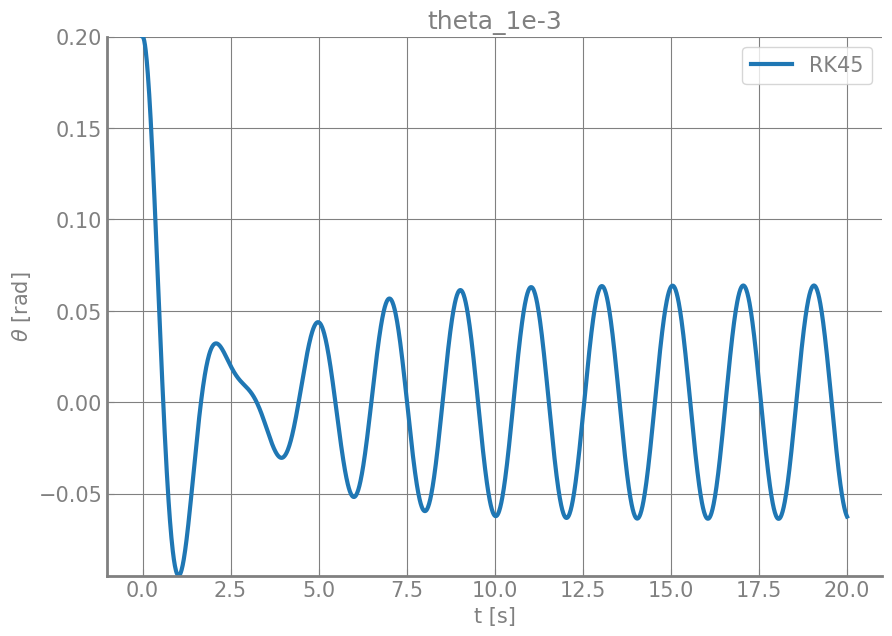

In [58]:
wD = 3.13 # [1/s]
T = 20 # [s]
dt = 1e-2 # [s]

RHS = partial(equation_RK45, wD=wD)
theta_vals, omega_vals, t_vals = RK45_solver(
    RHS=RHS,
    T=T,
    dt=dt,
    theta_0=theta_0,
    omega_0=omega_0
)
plot_data(
    x_arrays=[t_vals],
    y_arrays=[theta_vals],
    legends=["RK45"],
    xlabel="t [s]",
    ylabel=r"$\theta$ [rad]",
    title="theta_1e-3"
)


## Oppg. 2

In [61]:
def convergence_test(solver: Callable) -> tuple[np.ndarray, np.ndarray]:
    dt_increment = 1e-4
    T = [1, 10, 20]
    dt_range = np.arange(1e-3, 1e-2+dt_increment, dt_increment)

    differance = np.zeros_like(dt_range)
    prev_theta_arr, prev_omega_arr, _ = solver(T[-1], dt_range[0], theta_0, omega_0)
    # prev_theta = prev_theta_arr[-1]
    # prev_omega = prev_omega_arr[-1]
    # prev_energy = energy(prev_theta, prev_omega)
    prev_integral = np.sum(prev_theta_arr)*dt_range[0]
    

    for i, dt in enumerate(dt_range):
        theta_arr, omega_arr, t_arr = solver(T[-1], dt, theta_0, omega_0)
        # E = energy(theta_arr[-1], omega_arr[-1]) 
        integral = np.sum(theta_arr)*dt
        differance[i] = abs(integral - prev_integral)
        prev_integral = integral
    
    return differance, dt_range

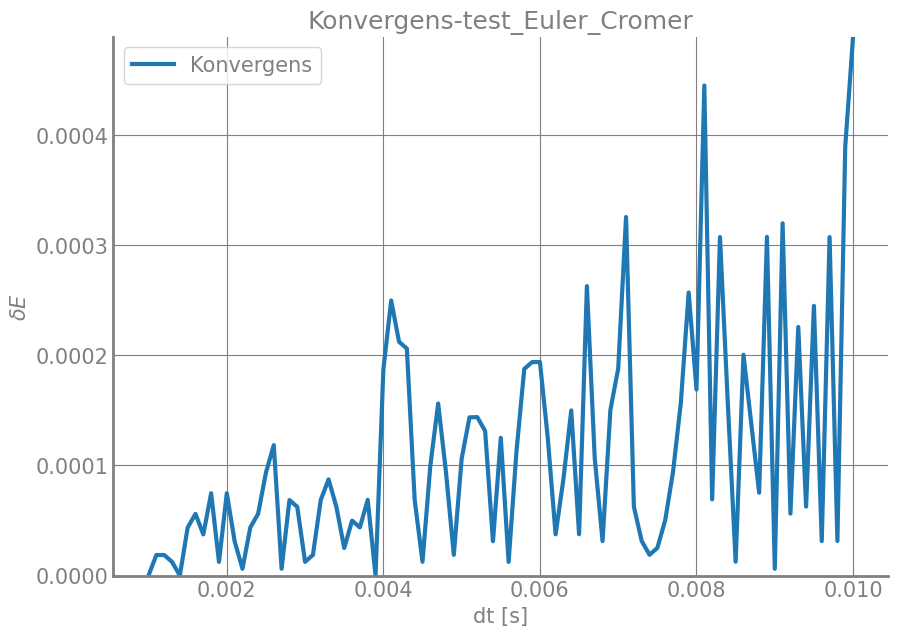

In [62]:
d_omega_equation = partial(d_omega_equation_Euler_Cromer, wD=wD)
euler_cromer_solver = partial(Euler_Cromer_solver, d_omega_equation)

differance, dt_range = convergence_test(euler_cromer_solver)

plot_data(
    x_arrays=[dt_range],
    y_arrays=[differance],
    legends=["Konvergens"],
    xlabel="dt [s]",
    ylabel=r"$\delta E$",
    title="Konvergens-test_Euler_Cromer"
)